In [1]:
import os
import tensorflow as tf
import tensorflow.keras as K
import numpy as np
import pandas as pd
import math
from PIL import Image
import sys
import random

In [2]:
# !pip3 install pandas

In [3]:
tf.__version__

'2.6.0-dev20210425'

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=6500)])
  except RuntimeError as e:
    print(e)

In [6]:
from utils import movie_images_to_dict

In [7]:
trainning_folder="training_images"
test_folder="test"

In [8]:
number_of_trainning_videos=1
number_of_test_videos=1

In [9]:
trainning_data_set=[]
test_data_set=[]
# Loop through trainning images
for index in range(number_of_trainning_videos):
    trainning_data_set.append(pd.DataFrame(movie_images_to_dict.get_images_to_dict(f'{trainning_folder}/{index}/')).to_numpy())
# Loop through test images
for index in range(number_of_test_videos):
    test_data_set.append(pd.DataFrame(movie_images_to_dict.get_images_to_dict(f'{test_folder}/{index}/')).to_numpy())

In [10]:
pd.DataFrame(trainning_data_set[0])

,0,1,2,3
0,000000.png,training_images/0/,1080,1920
1,000001.png,training_images/0/,1080,1920
2,000002.png,training_images/0/,1080,1920
3,000003.png,training_images/0/,1080,1920
4,000004.png,training_images/0/,1080,1920
...,...,...,...,...
108,000108.png,training_images/0/,1080,1920
109,000109.png,training_images/0/,1080,1920
110,000110.png,training_images/0/,1080,1920
111,000111.png,training_images/0/,1080,1920


In [11]:
# Split in to groups
def split_in_groups(dataset,number_of_images=2,step=1):
#     Generate in groups
    dataset_gen=[dataset[i : i + number_of_images] for i in range(0, len(dataset), step) if i+number_of_images<len(dataset)]
#     Return as a numpy group
    return np.array(dataset_gen)


# Trainning groups
trainning_groups=[]
for i in range(number_of_trainning_videos):
    trainning_groups.append(split_in_groups(trainning_data_set[i],6))
trainning_groups=np.concatenate(trainning_groups,axis=0)                            
                            

# Test groups
test_groups=[]
for i in range(number_of_test_videos):
    test_groups.append(split_in_groups(test_data_set[i],6))                
test_groups=np.concatenate(test_groups,axis=0)

In [12]:
input_shape=(int(1080/8),int(1920/8),3)
input_shape

(135, 240, 3)

In [13]:
resize_and_rescale = tf.keras.Sequential([
  K.layers.experimental.preprocessing.Resizing(input_shape[0],input_shape[1], interpolation='nearest'),
  K.layers.experimental.preprocessing.Rescaling(1./255)
])
@tf.function
def resize_image(images,y):
    new_images=[]
    for image in images:
        new_images.append(resize_and_rescale(image))
    # print(new_images)
    return tuple(new_images),y
    
# Gen
# def trainning_group_gen():
#     for trainning_group in trainning_groups:
#         images=[]
#         for record in trainning_group:
#             image=Image.open(record[1]+record[0])
#             image=image.resize((input_shape[1],input_shape[0]))
#             images.append(np.array(image)/255)

#         yield tuple(images),1
#         yield tuple(images[::-1]),0
# @tf.function
def trainning_group_gen2():
    for trainning_group in trainning_groups:
        images=[]
        for record in trainning_group:
            image=Image.open(record[1]+record[0])
            images.append(np.array(image))

        yield tuple(images),1
        yield tuple(images[::-1]),0
        
# def test_group_gen():
#     for test_group in test_groups:
#         images=[]
#         for record in test_group:
#             image=Image.open(record[1]+record[0])
#             image=image.resize((input_shape[1],input_shape[0]))
#             images.append(np.array(image)/255)
#         yield tuple(images),1
#         yield tuple(images[::-1]),0
def test_group_gen2():
    for trainning_group in test_groups:
        images=[]
        for record in trainning_group:
            image=Image.open(record[1]+record[0])
            images.append(np.array(image))

        yield tuple(images),1
        yield tuple(images[::-1]),0

In [14]:
# tensor_trainning_dataset=tf.data.Dataset.from_generator(
#     trainning_group_gen,
#     output_signature=(
#     (tf.TensorSpec(shape=input_shape, dtype=tf.float32),tf.TensorSpec(shape=input_shape, dtype=tf.float32)),
#         tf.TensorSpec(shape=(), dtype=tf.int8)
#     )
# ).batch(20).prefetch(tf.data.AUTOTUNE)


# tensor_trainning_dataset2=tf.data.Dataset.from_generator(
#     trainning_group_gen2,
#     output_signature=(
#     (tf.TensorSpec(shape=(1080,1920,3), dtype=tf.float32),tf.TensorSpec(shape=(1080,1920,3), dtype=tf.float32),tf.TensorSpec(shape=(1080,1920,3), dtype=tf.float32),tf.TensorSpec(shape=(1080,1920,3), dtype=tf.float32),tf.TensorSpec(shape=(1080,1920,3), dtype=tf.float32),tf.TensorSpec(shape=(1080,1920,3), dtype=tf.float32)),
#         tf.TensorSpec(shape=(), dtype=tf.int8)
#     )
# ).map(resize_image, num_parallel_calls=tf.data.AUTOTUNE).batch(20).prefetch(tf.data.AUTOTUNE)

tensor_trainning_dataset2 = tf.data.Dataset.from_generator(
     trainning_group_gen2,
     ((tf.float32, tf.float32,tf.float32, tf.float32,tf.float32, tf.float32),tf.int8),
     (
         (tf.TensorShape([1080, 1920, 3]),tf.TensorShape([1080, 1920, 3]),tf.TensorShape([1080, 1920, 3]),tf.TensorShape([1080, 1920, 3]),tf.TensorShape([1080, 1920, 3]),tf.TensorShape([1080, 1920, 3])
    )
    ,tf.TensorShape([])
    )).map(resize_image, num_parallel_calls=8).batch(20).prefetch(8)
# tensor_test_dataset=tf.data.Dataset.from_generator(
#     test_group_gen,
#     output_signature=(
#     (tf.TensorSpec(shape=input_shape, dtype=tf.float32),tf.TensorSpec(shape=input_shape, dtype=tf.float32),tf.TensorSpec(shape=input_shape, dtype=tf.float32),tf.TensorSpec(shape=input_shape, dtype=tf.float32),tf.TensorSpec(shape=input_shape, dtype=tf.float32),tf.TensorSpec(shape=input_shape, dtype=tf.float32)),
#         tf.TensorSpec(shape=(), dtype=tf.int8)
#     )
# ).batch(3).prefetch(tf.data.AUTOTUNE)

In [15]:

# tf.math.reduce_mean(np.array([[1,2,3],[2,3,4]],dtype=np.float32),axis=0)

In [16]:
for i in tensor_trainning_dataset2.take(2):
    print(i)
    # break

((<tf.Tensor: shape=(20, 135, 240, 3), dtype=float32, numpy=
array([[[[0.3921569 , 0.4431373 , 0.23137257],
         [0.3372549 , 0.39607847, 0.14509805],
         [0.32156864, 0.3803922 , 0.12941177],
         ...,
         [0.35686275, 0.37647063, 0.20000002],
         [0.36078432, 0.3803922 , 0.20392159],
         [0.43921572, 0.45882356, 0.2901961 ]],

        [[0.3803922 , 0.43137258, 0.21960786],
         [0.3529412 , 0.40784317, 0.16862746],
         [0.34901962, 0.40784317, 0.14901961],
         ...,
         [0.37647063, 0.39607847, 0.21960786],
         [0.39607847, 0.4156863 , 0.2392157 ],
         [0.40000004, 0.41960788, 0.24313727]],

        [[0.3372549 , 0.3921569 , 0.16862746],
         [0.37647063, 0.43529415, 0.18431373],
         [0.32156864, 0.3803922 , 0.12156864],
         ...,
         [0.40784317, 0.43921572, 0.2392157 ],
         [0.3529412 , 0.37647063, 0.18039216],
         [0.36862746, 0.38823533, 0.20392159]],

        ...,

        [[0.5019608 , 0.5215686

((<tf.Tensor: shape=(20, 135, 240, 3), dtype=float32, numpy=
array([[[[0.4156863 , 0.4666667 , 0.25490198],
         [0.34117648, 0.40000004, 0.14901961],
         [0.32156864, 0.3803922 , 0.12941177],
         ...,
         [0.36078432, 0.3803922 , 0.20392159],
         [0.36078432, 0.3803922 , 0.20392159],
         [0.46274513, 0.48235297, 0.3137255 ]],

        [[0.38431376, 0.43529415, 0.22352943],
         [0.35686275, 0.41176474, 0.17254902],
         [0.34901962, 0.40784317, 0.14901961],
         ...,
         [0.39607847, 0.4156863 , 0.2392157 ],
         [0.4039216 , 0.42352945, 0.24705884],
         [0.40000004, 0.41960788, 0.24313727]],

        [[0.32941177, 0.38431376, 0.16078432],
         [0.37647063, 0.43529415, 0.18431373],
         [0.3254902 , 0.38431376, 0.1254902 ],
         ...,
         [0.5294118 , 0.5647059 , 0.34509805],
         [0.36078432, 0.38431376, 0.18039216],
         [0.37254903, 0.39607847, 0.20000002]],

        ...,

        [[0.5019608 , 0.5215686

In [17]:

def block(block,num_filters):
    block=K.layers.Conv2D(num_filters,3,padding='same')(block)
    block=K.layers.LeakyReLU()(block)
    block=K.layers.BatchNormalization()(block)
    # block=K.layers.Dropout(.1)(block)
    block=K.layers.MaxPool2D((3,3))(block)
    return block
start=K.layers.Input(shape=input_shape)
block_1=block(start,64)
block_2=block(block_1,128)
block_3=block(block_2,256)
block_4=block(block_3,512)
global_max=K.layers.GlobalMaxPool2D()(block_4)
conv=K.Model(inputs=start,outputs=global_max)


image_1=K.Input(input_shape)
image_2=K.Input(input_shape)
image_3=K.Input(input_shape)
image_4=K.Input(input_shape)
image_5=K.Input(input_shape)
image_6=K.Input(input_shape)

image_1_nn=conv(image_1)
image_2_nn=conv(image_2)
image_3_nn=conv(image_3)
image_4_nn=conv(image_4)
image_5_nn=conv(image_5)
image_6_nn=conv(image_6)

def add(images):
    return images[0]+images[1]+images[2]+images[3]+images[4]+images[5]

lambda_layer=tf.keras.layers.Concatenate()([image_1_nn,image_2_nn,image_3_nn,image_4_nn,image_5_nn,image_6_nn])
fc_1=K.layers.Dense(200)(lambda_layer)
fc_1=K.layers.LeakyReLU()(fc_1)
# fc_1=K.layers.Dense(200)(fc_1)
# fc_1=K.layers.LeakyReLU()(fc_1)
fc_2=K.layers.Dense(2,activation='tanh')(fc_1)
# bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)
model=K.Model(inputs=[image_1,image_2,image_3,image_4,image_5,image_6],outputs=fc_2)


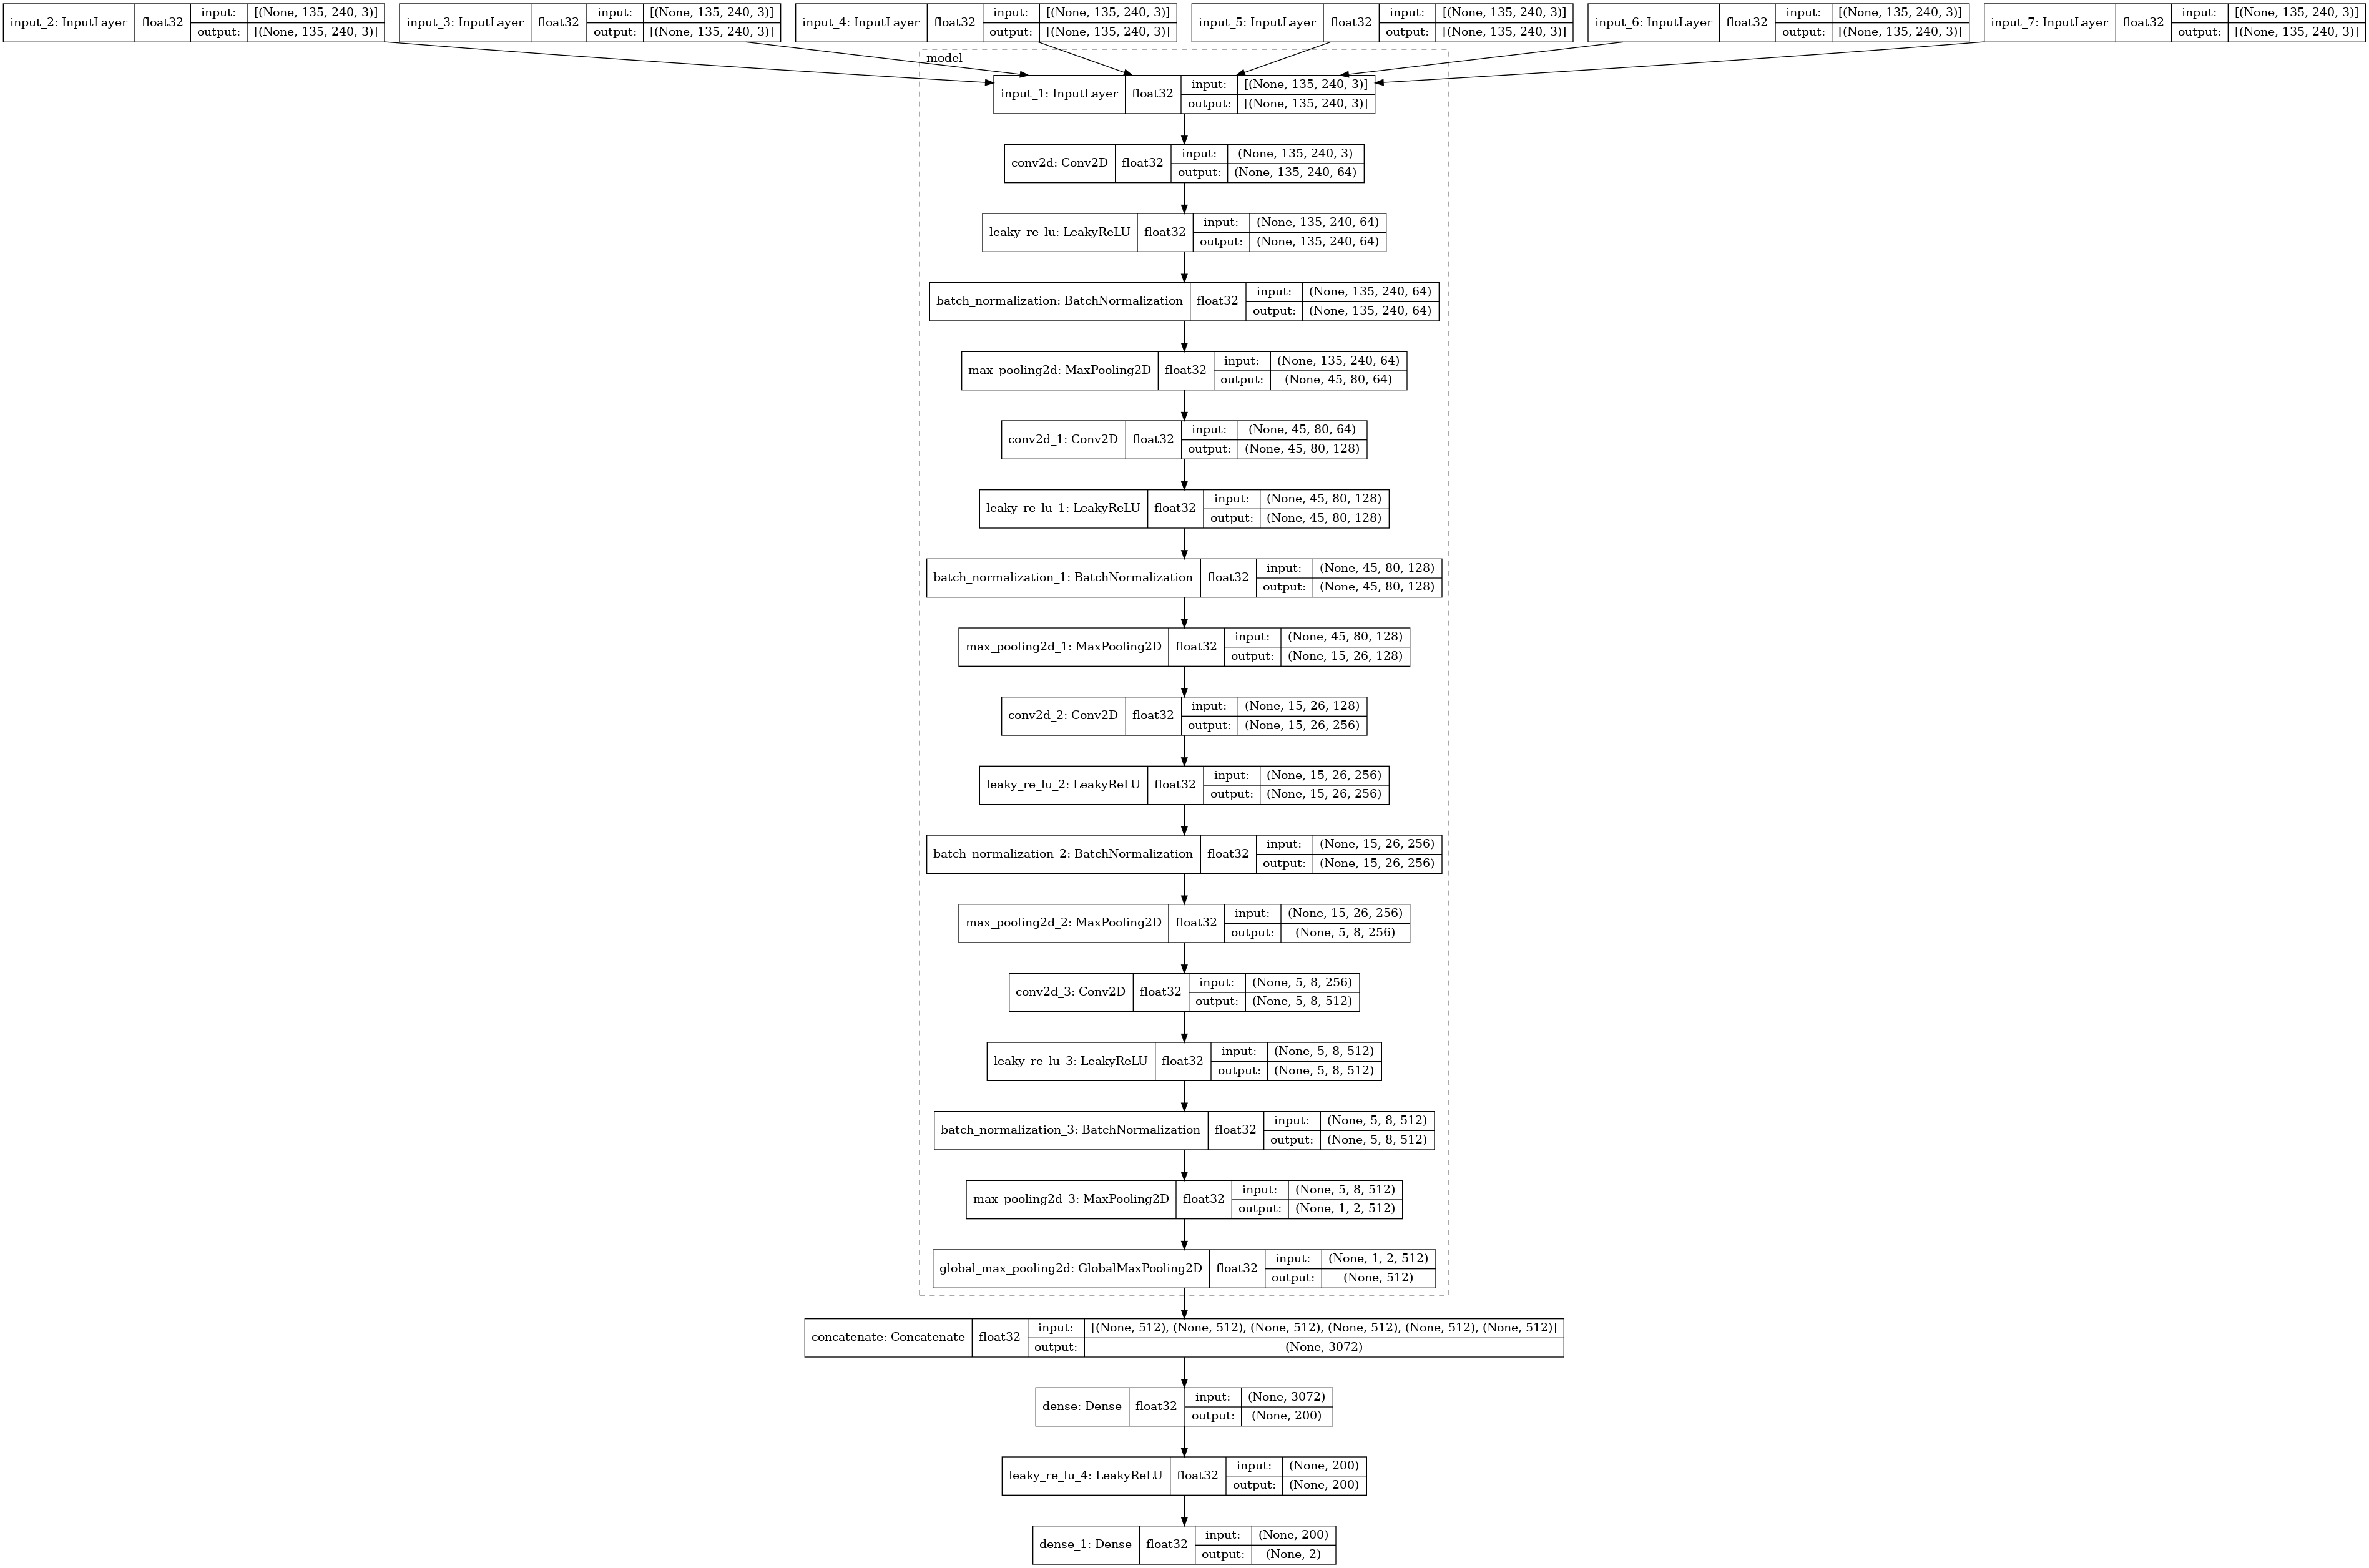

In [18]:
K.utils.plot_model(model,show_shapes=True,expand_nested=True,show_dtype=True)

In [19]:
# run_opts = tf.RunOptions(report_tensor_allocations_upon_oom = True)
model.compile(
#     options = run_opts,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=K.optimizers.Adam(learning_rate=0.0005),
    metrics=[tf.keras.metrics.BinaryAccuracy(),tf.keras.metrics.MeanSquaredError()]
)

In [20]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 135, 240, 3) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 135, 240, 3) 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 135, 240, 3) 0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 135, 240, 3) 0                                            
____________________________________________________________________________________________

In [ ]:
history=model.fit(tensor_trainning_dataset2,epochs=500)

Epoch 1/500
11/11 [==============================] - 29s 2s/step - loss: 2.0439 - binary_accuracy: 0.5000 - mean_squared_error: 2.1293
Epoch 2/500
11/11 [==============================] - 27s 2s/step - loss: 0.6931 - binary_accuracy: 0.5000 - mean_squared_error: 2.5000
Epoch 3/500
 5/11 [============>.................] - ETA: 15s - loss: 0.6931 - binary_accuracy: 0.5000 - mean_squared_error: 2.5000